# Machine Learning: Project 2
## Task 1

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

### Loading, Normalizing and Splitting the Data

In [ ]:
lfw_people = fetch_lfw_people(
    data_home="/media/abdelrahman/CE92DD4992DD3725/GUC/Semester 9 Winter 2018/CSEN1067. Machine Learning Algorithms/Project/Project 1/code/project2/datasets/task1/lfw_funneled",
    min_faces_per_person=70, resize=0.4,download_if_missing= True)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:",X.shape)
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# Standardize the data set
X = (X - X.mean()) / X.std()

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### C values in SVM model
In the code cell below, for the four C values (1, 10, 100, 1000) in our SVM Classifier:
- 10 got the best results because when C is small it tends to ignore the errors thus resulting in bad validation and test scores, on the other hand, when C grows large it's more likely to adapt to the training data (with a tendancy to not overlook errors which may lead to overfitting) such that it misclassifies the training data. So, the value 10 did best as it was not too large or too small.
- In the tutorial, the best value for C was 1000. It is also possible that this value of C was best because the data hadn't been normalized yet

### Time taken with and without grid search (best estimator only - grid search for best estimator)
Normal runtime: (4.9 - 130.2)

GPU: (3.3 - 87.8)

TPU: (4.8 - 128.3)

- Time taken for the GPU is much less than normal run time and of the TPU. TPUs are not not independent processors, they cannot execute code in its own right, all code execution takes place on the CPU which just feeds a stream of microoperations to the TPU which may provide smaller training time compared to the normal CPU especially tensorflow operations (In general GPUs are faster).

In [0]:
# Train a SVM classification model
print("Fitting the classifier to the training set")
print("Total dataset size:",X.shape)
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

param_grid = {'C': [1e0, 1e1, 1e2, 1e3]}  #'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1,0.5,1] too slow for now
clf = GridSearchCV(SVC(), param_grid, cv=5, iid=False)

start_time = time.time()

clf = clf.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print("C-value of best estimator found by grid search:", clf.best_estimator_.C)
print("elapsed training time for the best classifier:",elapsed_time)

Fitting the classifier to the training set
Total dataset size: (1288, 1850)
n_samples: 1288
n_features: 1850
n_classes: 7
C-value of best estimator found by grid search: 10.0
elapsed training time for the best classifier: 130.26528239250183


### PCA usage
Using PCA is supposed to accelerate the learning process and it did. We used 5 different values for PCA (50, 150, 190, 300 and 1000) and found the best corresponding C-value. The results are plotted below.

In [0]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction
used_n_components = []
best_cs = []
performance_acc = []
best_acc = 0
best_PCA = 0
n_components_arr = [50, 150, 190, 300, 1000]
for n_components in n_components_arr:
    print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
    try:
        pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
        used_n_components.append(n_components)
    except ValueError:
        print(n_components, "is too large of a value! Max value allowed is", min(X_train.shape[0], n_features))
        break
        
    eigenfaces = pca.components_.reshape((n_components, h, w))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    print("Fitting the classifier to the training set")
    param_grid = {'C': [1, 1e1, 1e2, 1e3]}
    clf = GridSearchCV(SVC(), param_grid, cv=5, iid=False)
    clf = clf.fit(X_train_pca, y_train)

    print("C-value of best estimator found by grid search:", clf.best_estimator_.C)
    best_cs.append(clf.best_estimator_.C)
    performance_acc.append(clf.score(X_test_pca, y_test) * 100)
    print("score: ",clf.score(X_test_pca, y_test) * 100)
    print("")
    
    


Extracting the top 50 eigenfaces from 1030 faces
Projecting the input data on the eigenfaces orthonormal basis
Fitting the classifier to the training set
C-value of best estimator found by grid search: 10.0
score:  85.27131782945736

Extracting the top 150 eigenfaces from 1030 faces
Projecting the input data on the eigenfaces orthonormal basis
Fitting the classifier to the training set
C-value of best estimator found by grid search: 10.0
score:  85.65891472868216

Extracting the top 190 eigenfaces from 1030 faces
Projecting the input data on the eigenfaces orthonormal basis
Fitting the classifier to the training set
C-value of best estimator found by grid search: 10.0
score:  84.88372093023256

Extracting the top 300 eigenfaces from 1030 faces
Projecting the input data on the eigenfaces orthonormal basis
Fitting the classifier to the training set
C-value of best estimator found by grid search: 10.0
score:  80.62015503875969

Extracting the top 1000 eigenfaces from 1030 faces
Projecting

### Results
The following graph shows the performance of the classifiers we obtained from the gridsearch above. The vertical axis is the accuracy (in percent) of the classifier on the test data, while the horizontal axis is the label denoting the C-value that was chosen GridSearch and the number of PCA components used. From this data, we find:

1. Increasing PCA components helped increase the accuracy when going from 50 to 150 which could mean that 50 dimensions was too few dimensions to help classify the data.
2. Increasing PCA components higher than 150 sees to cause a loss in performance. Perhaps the columns with the highest covariance after the first 150 are causing some noise which makes it harder to classify.

In our results, the best performing SVC had PCA with 150 components and a C-value of 10. The results are validated using multiple runs in which the 150 PCA provided better and more consistent results.

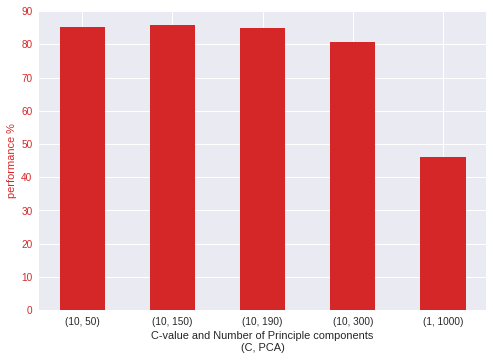

In [0]:
fig, ax1 = plt.subplots()
plt.xticks(np.arange(len(used_n_components)), list(zip(np.array(best_cs).astype(int), used_n_components)))

width = 0.5

ax1.set_xlabel('C-value and Number of Principle components\n(C, PCA)')

color = 'tab:red'
ax1.set_ylabel('performance %', color=color)
ax1.bar(np.arange(len(performance_acc)), performance_acc, color=color, width=width)
ax1.tick_params(axis='y', labelcolor=color)

plt.show()

In [0]:
# Quantitative evaluation of the model quality on the test set

# Best PCA and SVC
n_components = 150
C = 10
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
clf = SVC(C=C)
clf.fit(X_train_pca, y_train)

print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)

# print(classification_report.__doc__)

print(classification_report(y_test, y_pred, labels=range(n_classes), target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.45      0.62        11
     Colin Powell       0.79      0.89      0.84        47
  Donald Rumsfeld       1.00      0.64      0.78        22
    George W Bush       0.82      0.97      0.89       119
Gerhard Schroeder       1.00      0.84      0.91        19
      Hugo Chavez       1.00      0.54      0.70        13
       Tony Blair       1.00      0.78      0.88        27

      avg / total       0.88      0.86      0.85       258

[[  5   1   0   5   0   0   0]
 [  0  42   0   5   0   0   0]
 [  0   2  14   6   0   0   0]
 [  0   3   0 116   0   0   0]
 [  0   1   0   2  16   0   0]
 [  0   3   0   3   0   7   0]
 [  0   1   0   5   0   0  21]]


In [0]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

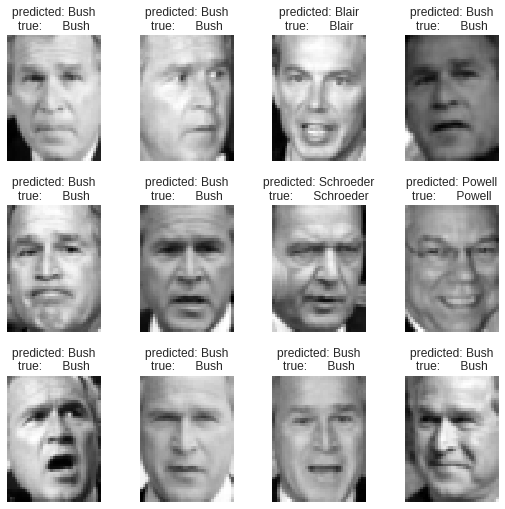

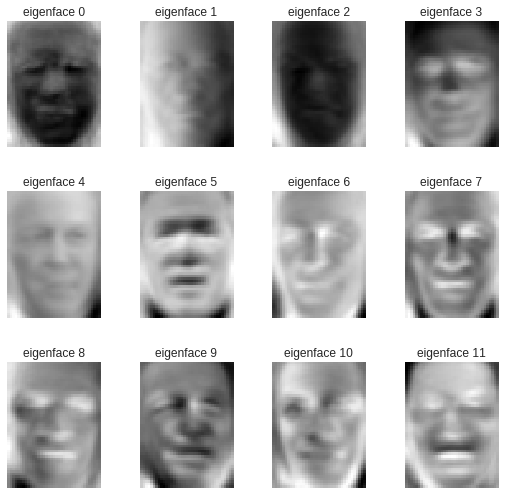

In [0]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

### Unfunnled  Datatset and Eigenfaces Comparison

- Results obtained in the unfunneled dataset are worse than the funneled one, with with an average of 83% accuracy compared to an average of almost 86%.
- It is also apparent from the eigenfaces that the features are more apparent in the funelled dataset as the more prominent features (like the eyes and lips) are more higlighted in the eigenfaces in the unfunelled dataset.
- The funneled dataset is different from the unfunelled dataset in the sense that it realigns the face so that it is oriented in a way that makes recognition algorithms more likely to correctly process/classify it. In this way, the main features of the face are more likely to be in the same absolute coordinates (with some error) with respect to the coordinate system that contains the image.
- An Image may have different illumination or a face may have different poses. these conditions may affect the classification.
- funneling or allignment improves positioning for subsequent processing, such as an identification task by placing objects in the same canonical pose. This difference is shown and distinguishible between the eigen faces for the funneled and the unfunneled datasets (eigen faces of the funneled dataset are more distinguishible and the results confirms theses finidings as well). also the positioning of the face features differ between the 2 approaches, it is apparent that features such as eye and mouth tend to be more semmetric and alligned with the rest of the face in most examples.

References
1. https://pdfs.semanticscholar.org/b7a7/84af74c4b7cba38f7c5a8f11dbb292bb5307.pdf
2. http://vis-www.cs.umass.edu/papers/iccv07alignment.pdf

In [ ]:
#load dataset
lfw_people = fetch_lfw_people(
    min_faces_per_person=70, resize=0.4,download_if_missing= True,funneled = False)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:",X.shape)
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# Standardize the data set
X = (X - X.mean()) / X.std()

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

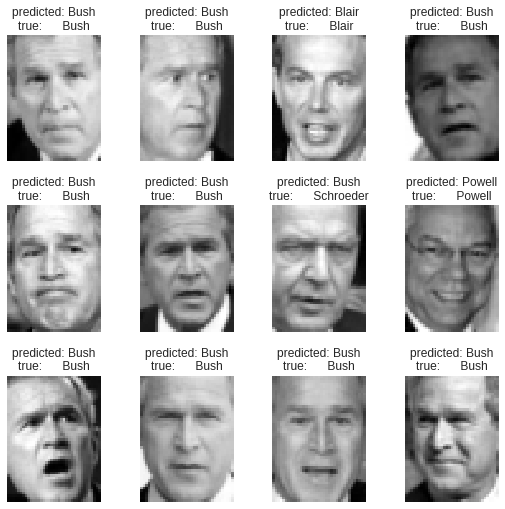

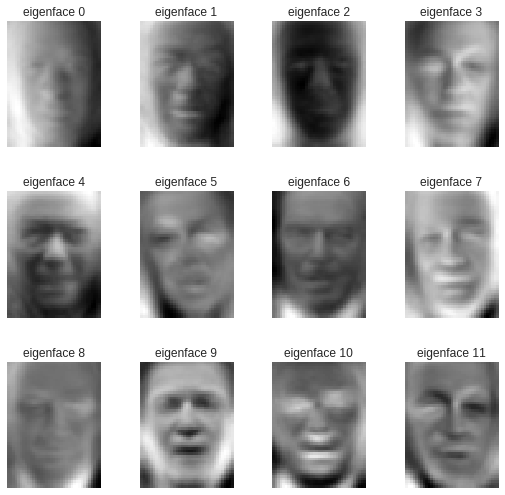

In [0]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()